In [1]:
import multiprocessing
import chess
import numpy as np
import time

SIZE = 8

# DO NOT CHANGE THE ORDER OF THE ITEMS!
DIRECTIONS = [(1, 1), (1, 0), (1, -1), (0, -1), (-1, -1), (-1, 0), (-1, 1), (0, 1)]
DIRECTIONS_OFFSETS = [SIZE + 1, SIZE, SIZE - 1, -1, -(SIZE + 1), -SIZE, -(SIZE - 1), 1]
eval_times = {}

def calculate_move(me: int, move: tuple[int, int], board: tuple[int, int]) -> tuple[int, int]:
    """
    `me` should be 0 or 1.
    """
    taken_places, colors = board

    row, col = move
    move_position_bit = 1 << (row * SIZE + col)

    colors_flip = 0

    for (d_row, d_col), bit_offset in zip(DIRECTIONS, DIRECTIONS_OFFSETS):
        row, col = move

        bit = move_position_bit
        flip_n = 0

        should_affect = False

        while True:
            row += d_row
            col += d_col

            if row >= SIZE or row < 0 or col >= SIZE or col < 0:
                break

            if bit_offset < 0:
                bit >>= -bit_offset
            else:
                bit <<= bit_offset

            if not (taken_places & bit):  # encountered empty place
                break

            if ((colors & bit) > 0) is (me > 0):  # a connection was made
                should_affect = True
                break

            flip_n |= bit

        if should_affect:
            colors_flip ^= flip_n

    if me:
        colors_flip |= move_position_bit  # flip the selected move position color

    return move_position_bit, colors_flip


def apply_move(board: tuple[int, int], move_flip: tuple[int, int]) -> tuple[int, int]:
    taken_places, colors = board
    position_flip, colors_flip = move_flip

    return taken_places ^ position_flip, colors ^ colors_flip


def translate_to_bin(board: list[list[int]]) -> tuple[int, int]:
    """
    2 values -> 1
    1 values -> 0
    | or , & and , ^ xor , ~ not , << shift left, >> shift right
    """
    taken_places, colors = 0, 0
    bit = 1

    for row in range(SIZE):
        for col in range(SIZE):
            value = board[row][col]
            if value != 0:
                taken_places |= bit

            if value == 2:
                colors |= bit

            bit <<= 1

    return taken_places, colors


def translate_bin_board_to_01none_lists(board: tuple[int, int]) -> list[list[int | None]]:
    taken_places, colors = board

    rows = []
    bit = 1
    for i in range(SIZE):
        row = []
        for j in range(SIZE):
            is_taken_place = taken_places & bit

            if is_taken_place:
                color = (colors & bit) > 0
                row.append(color)
            else:
                row.append(None)
            bit <<= 1

        rows.append(row)
    return rows


def translate_bin_move_to_row_col(bin_move):
    move_position_bit, _ = bin_move
    position_in_board = 0
    while move_position_bit:
        position_in_board += 1
        move_position_bit >>= 1
    position_in_board -= 1

    row, col = divmod(position_in_board, SIZE)
    return row, col


def count_binary_1s(n: int) -> int:
    c = 0
    while n != 0:
        if n & 1:
            c += 1
        n >>= 1
    return c


def preview_board(board: tuple[int, int]):
    taken_places, colors = board

    bit = 1
    board_repr = ""
    for i in range(SIZE):
        for j in range(SIZE):
            is_place_taken = taken_places & bit
            if not is_place_taken:
                board_repr += "."
            else:
                board_repr += "1" if colors & bit else "0"
            bit <<= 1
        board_repr += "\n"
    return board_repr


STARTING_BOARD = [[0] * SIZE for _ in range(SIZE)]
STARTING_BOARD[SIZE // 2 - 1][SIZE // 2 - 1] = 1
STARTING_BOARD[SIZE // 2][SIZE // 2] = 1
STARTING_BOARD[SIZE // 2 - 1][SIZE // 2] = 2
STARTING_BOARD[SIZE // 2][SIZE // 2 - 1] = 2

STARTING_BIN_BOARD = translate_to_bin(STARTING_BOARD)


########################################################################################################################


def get_available_moves(me, board):
    moves = []

    taken_places, colors = board

    bit = 1
    for row in range(SIZE):
        for col in range(SIZE):
            if not taken_places & bit:  # I.E. place is not taken
                move = (row, col)
                bin_move = calculate_move(me, move, board)
                position_bit, colors_flip = bin_move
                if (colors_flip & (~position_bit)) != 0:  # equivalent to "is valid move?"
                    moves.append(bin_move)

            bit <<= 1
    return moves


def order_moves(moves, start_with_move):
    moves__with_values = []
    for move in moves:
        if move == start_with_move:
            value = float('inf')

        else:
            location, color_flip = move
            pieces_flipped = count_binary_1s(color_flip)
            if location & color_flip == location:
                pieces_flipped -= 1
            value = -pieces_flipped

            row, col = translate_bin_move_to_row_col(move)
            if row == 0 or row == SIZE - 1:
                value += 7
            if col == 0 or col == SIZE - 1:
                value += 7

        moves__with_values.append([value, move])

    ordered_moves = sorted(moves__with_values, key=lambda x: x[0])
    return [x[1] for x in ordered_moves]




# MASKING = rotate_masking(MASKING) 


def evaluate_board(board):
    global eval_times
    MASKING2 = [ 
        [100, -15, 15, 5, 5, 15, -15, 100],
        [-15, -50, 2, 0, 0, 2, -50, -15],
        [15, 2, 15, 0, 0, 15, 2, 15],
        [5, 0, 0, 3, 3, 0, 0, 5],
        [5, 0, 0, 3, 3, 0, 0, 5],
        [15, 2, 15, 0, 0, 15, 2, 15],
        [-15, -50, 2, 0, 0, 2, -50, -15],
        [100, -15, 15, 5, 5, 15, -15, 100]
    ]

    MASKING1 = [ 
        [100, -15, 15, 5, 5, 15, -15, 100],
        [-15, -50, 2, 0, 0, 2, -50, -15],
        [15, 2, 15, 0, 0, 15, 2, 15],
        [5, 0, 0, 3, 3, 0, 0, 5],
        [5, 0, 0, 3, 3, 0, 0, 5],
        [15, 2, 15, 0, 0, 15, 2, 15],
        [-15, -50, 2, 0, 0, 2, -50, -15],
        [100, -15, 15, 5, 5, 15, -15, 100]
    ]

    if not board[0][0]: ###### UPPER LEFT CORNER
        if board[0][0] == 2:
            MASKING2[0][1], MASKING2[1][0], MASKING2[1][1] = 15, 15, 15
            MASKING1[0][1], MASKING1[1][0], MASKING1[1][1] = 0, 0, 0
        else:
            MASKING1[0][1], MASKING1[1][0], MASKING1[1][1] = 15, 15, 15
            MASKING2[0][1], MASKING2[1][0], MASKING2[1][1] = 0, 0, 0    

    if not board[0][7]: ##### UPPER RIGHT CORNER
        if board[0][7] == 2:
            MASKING2[0][6], MASKING2[1][7], MASKING2[1][6] = 15, 15, 15
            MASKING1[0][6], MASKING1[1][7], MASKING1[1][6] = 0, 0, 0
        else:
            MASKING1[0][6], MASKING1[1][7], MASKING1[1][6] = 15, 15, 15
            MASKING2[0][6], MASKING2[1][7], MASKING2[1][6] = 0, 0, 0   

    if not board[7][0]: ##### LOWER LEFR CORNER
        if board[7][0] == 2:
            MASKING2[7][1], MASKING2[6][0], MASKING2[6][1] = 15, 15, 15
            MASKING1[7][1], MASKING1[6][0], MASKING1[6][1] = 0, 0, 0
        else:
            MASKING1[7][1], MASKING1[6][0], MASKING1[6][1] = 15, 15, 15
            MASKING2[7][1], MASKING2[6][0], MASKING2[6][1] = 0, 0, 0    

    if not board[7][7]: ##### LOWER RIGHT CORNER
        if board[7][7] == 2:
            MASKING2[7][6], MASKING2[6][7], MASKING2[6][6] = 15, 15, 15
            MASKING1[7][6], MASKING1[6][7], MASKING1[6][6] = 0, 0, 0
        else:
            MASKING1[7][6], MASKING1[6][7], MASKING1[6][6] = 15, 15, 15
            MASKING2[7][6], MASKING2[6][7], MASKING2[6][6] = 0, 0, 0                            


    bit = 1
    taken_places, colors = board
    first_player_taken_places, second_player_taken_places = 0, 0

    value = 0
    for row in range(SIZE):
        for col in range(SIZE):
            if taken_places & bit:
                masking_value1 = MASKING1[row][col]
                masking_value2 = MASKING2[row][col]
                if colors & bit:
                    value += masking_value2
                    first_player_taken_places += 1
                else:
                    value -= masking_value1
                    second_player_taken_places += 1

            bit <<= 1
    number_of_taken_places = first_player_taken_places + second_player_taken_places

    if number_of_taken_places >= 55:
        value += 10 * (first_player_taken_places - second_player_taken_places)
    else:
        value -= 0.1 * number_of_taken_places * (first_player_taken_places - second_player_taken_places)

    if first_player_taken_places == 0:
        return float('-inf')
    elif second_player_taken_places == 0:
        return float('inf')

    start_time = time.time()
    first_player_options_number = len(get_available_moves(1, board))
    second_player_options_number = len(get_available_moves(0, board))
    
    elapsed_time = time.time() - start_time
    eval_times['part_1'] = eval_times.get('part_1', 0) + elapsed_time
    
    value += number_of_taken_places / 4 * (first_player_options_number - second_player_options_number)

    lists_board = translate_bin_board_to_01none_lists(board)
    strips = []
    sum_sandwich_1 = 0
    sum_sandwich_2 = 0
    for i in range(SIZE):
        row_strip = []
        col_strip = []
        for j in range(SIZE):
            row_strip.append(lists_board[i][j])
            col_strip.append(lists_board[j][i])
        # maybe check if the strip is full
        strips.append(row_strip)
        strips.append(col_strip)

    for i in range(3, SIZE):
        left_diagonal_strip = []  # like /
        right_diagonal_strip = []  # like \
        for j in range(i + 1):
            left_diagonal_strip.append(lists_board[j][i - j])
            right_diagonal_strip.append(lists_board[j][(SIZE - i - 1) + j])
        # maybe check if the strip is full
        strips.append(left_diagonal_strip)
        strips.append(right_diagonal_strip)

    for strip in strips:
        sandwich_bread = None
        sandwich_content = None
        bread_start_index = 0
        bread_end_index = 0
        content_start_index = 0

        for i in range(len(strip)):
            color = strip[i]

            if color is None:
                sandwich_bread = None
                sandwich_content = None
                continue

            if sandwich_bread is None:
                sandwich_bread = color
                bread_start_index = i

            else:
                if color != sandwich_bread:
                    if sandwich_content is None:
                        sandwich_content = color
                        content_start_index = i

                elif sandwich_content is not None:  # a sandwich is ready
                    # score sandwich: TODO
                    bread_end_index = i
                    if bread_start_index == 0 or i == SIZE - 1:
                        pass
                    else:
                        pass

                    sandwich_bread = sandwich_content
                    bread_start_index = content_start_index
                    content_start_index = i

    # value += 3 * (white_sanwich_amount - black_sandwich_amount)
    # value += 3 * (white_edge_sanwich_amount - black_edge_sandwich_amount)
                    
    return value


########################################################################################################################

best_move_of_last_search = None
current_search_best_move = None


def minimax(board, depth, maximizing_player: bool, distance_from_root=0, alpha=-float('inf'), beta=float('inf'),
            had_moves_last_turn=True):
    global current_search_best_move

    available_moves = get_available_moves(1 if maximizing_player else 0, board)
    if distance_from_root == 0:
        available_moves = order_moves(available_moves, best_move_of_last_search)
    else:
        available_moves = order_moves(available_moves, None)

    if len(available_moves) == 0:
        if not had_moves_last_turn:
            return None, evaluate_board(board)
        return minimax(board, depth, not maximizing_player, distance_from_root + 1, alpha, beta, False)

    if maximizing_player:
        best_value = -float('inf')
        best_move = None

        for move in available_moves:
            board = apply_move(board, move)
            if depth == 1:
                child_value = evaluate_board(board)
            else:
                _, child_value, = minimax(board, depth - 1, False, distance_from_root + 1, alpha, beta)

            board = apply_move(board, move)  # reverse board to previous state

            if child_value > best_value:
                best_value = child_value
                best_move = move
                if distance_from_root == 0:
                    current_search_best_move = best_move

            alpha = max(alpha, best_value)
            if beta <= alpha:
                break

    else:
        best_value = float('inf')
        best_move = None
        for move in available_moves:
            board = apply_move(board, move)
            if depth == 1:
                child_value = evaluate_board(board)
            else:
                _, child_value = minimax(board, depth - 1, True, distance_from_root + 1, alpha, beta)
            board = apply_move(board, move)  # reverse board to previous state

            if child_value < best_value:
                best_value = child_value
                best_move = move
                if distance_from_root == 0:
                    current_search_best_move = best_move

            beta = min(beta, best_value)
            if beta <= alpha:
                break

    return best_move, best_value


def iterative_deepening_minimax(board, me, max_time, return_dict):
    start_time = time.time()

    global best_move_of_last_search

    depth = 1
    while True:
        best_move, _ = minimax(board, depth, me)

        if time.time() - start_time < max_time:
            return_dict['best_move'] = best_move
            best_move_of_last_search = best_move
        else:
            break

        print(depth)
        depth += 1


########################################################################################################################
def get_move(me: int, board: list[list[int]]) -> tuple[int, int]:
    bin_board = translate_to_bin(board)
    me = me - 1

    # Set the maximum time limit for minimax
    max_time = 0.48  # 0.6 seconds

    # Initialize a return dictionary to collect the best move
    return_dict = multiprocessing.Manager().dict()

    # Create a process to run minimax with a time limit
    process = multiprocessing.Process(target=iterative_deepening_minimax, args=(bin_board, me, max_time, return_dict))
    process.start()
    process.join(timeout=max_time)

    # If the process is still running, terminate it
    if process.is_alive():
        process.terminate()
        process.join()

    # Get the best move from the return dictionary
    best_move = return_dict.get('best_move', None)

    if best_move is None:
        best_move = current_search_best_move

    return translate_bin_move_to_row_col(best_move)


def main(*_):
    # t1 = time.perf_counter()
    # minimax(STARTING_BIN_BOARD, 9, True)
    # t2 = time.perf_counter()
    # print(t2 - t1)

    return_dict = multiprocessing.Manager().dict()
    process = multiprocessing.Process(target=iterative_deepening_minimax,
                                      args=(STARTING_BIN_BOARD, 1, 10, return_dict))

    process.start()
    process.join(timeout=10)
    if process.is_alive():
        process.terminate()
        process.join()
    # iterative_deepening_minimax(STARTING_BIN_BOARD, 0.5, 1, return_dict)

    print(return_dict.get('best_move', None))
    print("Eval Times:", eval_times)

In [153]:
if __name__ == '__main__':
    main()
    
# Nice function for playing against ourselves
# Add evaluation for stable disks that cannot be flipped
# When there is stable for example a corner or an e
# Density function
# Add an array of tracking times for each part of the code

None
Eval Times: {}


In [2]:
def reversi_to_chess_board(reversi_board):
    chess_board = chess.Board(fen='8/8/8/8/8/8/8/8')
    for i in range(len(reversi_board)):
        for j in range(len(reversi_board[i])):
            if reversi_board[i][j] == 1:
                chess_board.set_piece_at(i * 8 + j, chess.Piece(chess.PAWN, 1))
            elif reversi_board[i][j] == 2:
                chess_board.set_piece_at(i * 8 + j, chess.Piece(chess.PAWN, 0))

    return chess_board

In [3]:
def square_to_move(square):
    return (ord(square[0].lower()) -97, int(square[1]) - 1)

In [4]:
def bot_move(board, me, depth):
    best_move, best_value = get_move(me, board)
    position_bit, colors_flip = calculate_move(me, move, board)
    board = apply_move(board, (position_bit, colors_flip))
    return board, best_move, best_value

def human_move(board, me):
    move = input()
    move = square_to_move(move)
    position_bit, colors_flip = calculate_move(me, move, translate_to_bin(board))
    if (colors_flip & (~position_bit)) != 0:  # equivalent to "is valid move?"
        board = apply_move(translate_to_bin(board), (position_bit, colors_flip))
        return board
    else:
        print('Illegal move')
        print()
        return human_move(board, me)

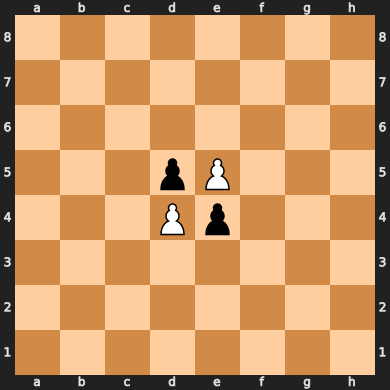

Black's turn


 c3


Illegal move



 c4


TypeError: object of type 'int' has no len()

In [5]:
board = STARTING_BOARD

turn = 1
for i in range(SIZE ** 2):
    if turn == 1:
        display(reversi_to_chess_board(board))
        print("Black's turn" if turn == 1 else "White's turn")
        board = human_move(board, turn)
        
    else:
        board, best_move, best_value = bot_move(me, board)
    display(reversi_to_chess_board(board))
    available_moves = get_available_moves(turn, board)
    if not len(available_moves) == 0:
        turn = 1 - turn
    else:
        print('No moves')
    print(best_move, best_value)        
        

In [6]:
move = square_to_move('a1')
print(move)
calculate_move(1, move, translate_to_bin(board))

(0, 0)


TypeError: 'int' object is not subscriptable

In [ ]:
def play()

In [48]:
preview_board(bin_board)

'01......\n........\n........\n...01...\n...10...\n........\n........\n........\n'

In [78]:
print(preview_board(STARTING_BIN_BOARD))

........
........
........
...01...
...10...
........
........
........



In [65]:
minimax(bin_board, 1, 1)

3 4
3 4
3 4
3 4


((524288, 134742016), -56.9)

In [64]:
bin_board = apply_move(STARTING_BIN_BOARD, (3, 2))

In [75]:
print(preview_board(apply_move(STARTING_BIN_BOARD, (3, 4))))

00......
........
........
...01...
...10...
........
........
........



In [34]:
binary_string = '0b1100000011000000010000000000000000000'

# Convert the binary string to a list of lists (8x8 matrix)
matrix = [[int(bit) for bit in binary_string[2 + i * 8:2 + (i + 1) * 8]] for i in range(8)]

# Print the visual representation of the matrix
for row in matrix:
    print(' '.join(map(str, row)))


1 1 0 0 0 0 0 0
1 1 0 0 0 0 0 0
0 1 0 0 0 0 0 0
0 0 0 0 0 0 0 0
0 0 0 0 0





In [ ]:
def density(board, me):

    taken_places, colors = board

    row, col = move
    move_position_bit = 1 << (row * SIZE + col)

    colors_flip = 0

    for (d_row, d_col), bit_offset in zip(DIRECTIONS, DIRECTIONS_OFFSETS):
        row, col = move

        bit = move_position_bit
        flip_n = 0

In [ ]:
def density(board, me):
    density = 0
    for i in binary_string:
        if me == 1:
            

In [ ]:
def density(board):
    board = translate_bin_to_reversi(board)
    for i in range(len(board)):
        for j in range(len(board)):
            if board[i][j] == 1:
                

In [ ]:
def density(board):
    for i in range(len(board)):
        for j in range(len(board)):
            if board[i][j] == 1:
                

In [81]:
def calculate_density(board, your_color):
    board_size = 8  # Adjust this to match your chess board size
    your_density = 0
    opponent_density = 0

    for row in range(board_size):
        for col in range(board_size):
            if board[row][col] == your_color:
                neighbors = [(row - 1, col - 1), (row - 1, col), (row - 1, col + 1),
                             (row, col - 1), (row, col + 1),
                             (row + 1, col - 1), (row + 1, col), (row + 1, col + 1)]

                for neighbor_row, neighbor_col in neighbors:
                    if 0 <= neighbor_row < board_size and 0 <= neighbor_col < board_size:
                        if board[neighbor_row][neighbor_col] == your_color:
                            your_density += 1
                        else:
                            opponent_density += 1

    total_your_pieces = sum(row.count(your_color) for row in board)
    total_opponent_pieces = sum(row.count(1 - your_color) for row in board)

    your_density /= total_your_pieces
    opponent_density /= total_opponent_pieces

    return your_density, opponent_density

In [87]:
# Usage example:
your_color = 1  # Replace with your color value (1 or 0)
board = [[0, 1, 1, 0, 0, 0, 1, 0],
         [1, 1, 0, 0, 0, 1, 0, 0],
         [0, 0, 0, 0, 0, 0, 0, 0],
         [0, 1, 0, 1, 1, 0, 1, 0],
         [0, 0, 0, 0, 0, 0, 0, 0],
         [0, 0, 1, 0, 0, 1, 0, 0],
         [0, 0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0, 0]]

density = calculate_density(translate_to_bin(board)[0], your_color)
print("Your density:", density)

ZeroDivisionError: division by zero

In [86]:
translate_to_bin(board)

(39583928558406, 0)

In [85]:
def calculate_density(taken_places, colors):
    board_size = 8  # Adjust this to match your chess board size
    your_color = 1  # Change to match your color (1 or 0)

    your_density = 0
    opponent_density = 0

    for row in range(board_size):
        for col in range(board_size):
            bit_position = row * board_size + col

            if (taken_places & (1 << bit_position)) != 0:
                if (colors & (1 << bit_position)) == your_color:
                    your_density += 1
                else:
                    opponent_density += 1

    total_your_pieces = bin(taken_places & colors).count('1')
    total_opponent_pieces = bin(taken_places & ~colors).count('1')

    your_density /= total_your_pieces
    opponent_density /= total_opponent_pieces

    return your_density, opponent_density


In [ ]:
taken_places 1
colors 0

In [ ]:
# Nice function for playing against ourself
# Sandwich maybe with bits
# Add evaluation for stable disks that cannot be flipped
# When there is stable for example a corner or an e

In [214]:
def count_neighbors(binary_string):
    if len(binary_string) != 64:
        raise ValueError("Input binary string must be of length 64")

    board = [int(bit) for bit in binary_string]
    result = []

    for i in range(8):
        for j in range(8):
            index = i * 8 + j
            if board[index] == 1:
                neighbors = 0
                for dx in [-1, 0, 1]:
                    for dy in [-1, 0, 1]:
                        if dx == 0 and dy == 0:
                            continue  # Skip the current square
                        ni, nj = i + dx, j + dy
                        if 0 <= ni < 8 and 0 <= nj < 8 and board[ni * 8 + nj] == 1:
                            neighbors += 1
                result.append(neighbors)
            else:
                result.append(0)

    return result

# Example usage:
binary_string = "1" * 23 + "0" * 10 + "1" * 31
a = time.time()

for i in range(10000):
    results = count_neighbors(binary_string)
    
print(time.time() - a)
print(results)

12.840317964553833
[3, 5, 5, 5, 5, 5, 5, 3, 5, 8, 8, 8, 8, 8, 7, 4, 3, 5, 5, 5, 5, 5, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 5, 5, 5, 5, 5, 3, 4, 7, 8, 8, 8, 8, 8, 5, 5, 8, 8, 8, 8, 8, 8, 5, 3, 5, 5, 5, 5, 5, 5, 3]


In [221]:
def count_neighbors(binary_number):
    if binary_number < 0 or binary_number > (1 << 64) - 1:
        raise ValueError("Input binary number must be a 64-bit integer")

    results = [0] * 64

    for i in range(64):
        if (binary_number >> i) & 1:
            neighbors = 0
            for offset in [-9, -8, -7, -1, 1, 7, 8, 9]:
                if 0 <= i % 8 + offset % 8 < 8 and 0 <= i // 8 + offset // 8 < 8:
                    neighbor_index = i + offset
                    if (binary_number >> neighbor_index) & 1:
                        neighbors += 1
            results[i] = neighbors

    return results

# Example usage:
binary_number = int("1" * 64, 2) # int("1" * 23 + "0" * 10 + "1" * 31, 2)
a = time.time()

for i in range(10000):
    results = count_neighbors(binary_number)
    
print(time.time() - a)
print(results)

1.1548972129821777
[4, 3, 3, 3, 3, 3, 3, 1, 7, 5, 5, 5, 5, 5, 5, 2, 8, 5, 5, 5, 5, 5, 5, 2, 8, 5, 5, 5, 5, 5, 5, 2, 8, 5, 5, 5, 5, 5, 5, 2, 8, 5, 5, 5, 5, 5, 5, 2, 8, 5, 5, 5, 5, 5, 5, 2, 6, 3, 3, 3, 3, 3, 3, 1]


In [217]:
"1" * 23 + "0" * 10 + "1" * 31

'1111111111111111111111100000000001111111111111111111111111111111'

In [218]:
def visualize_binary_board(binary_string):
    if len(binary_string) != 64:
        raise ValueError("Input binary string must be of length 64")

    for i in range(0, 64, 8):
        row = binary_string[i:i+8]
        row_visual = " ".join("X" if char == "1" else " " for char in row)
        print(row_visual)

# Example usage:
binary_string = "1" * 23 + "0" * 10 + "1" * 31
visualize_binary_board(binary_string)


X X X X X X X X
X X X X X X X X
X X X X X X X  
               
  X X X X X X X
X X X X X X X X
X X X X X X X X
X X X X X X X X


In [216]:
[3, 5, 5, 5, 5, 5, 5, 3, 5, 8, 8, 8, 8, 8, 7, 4, 3, 5, 5, 5, 5, 5, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 5, 5, 5, 5, 5, 3, 4, 7, 8, 8, 8, 8, 8, 5, 5, 8, 8, 8, 8, 8, 8, 5, 3, 5, 5, 5, 5, 5, 5, 3]
[4, 5, 5, 5, 5, 5, 5, 6, 7, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 7, 6, 5, 5, 5, 5, 5, 5, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 5, 5, 5, 5, 5, 5, 6, 7, 8, 8, 8, 8, 8, 7, 6, 5, 5, 5, 5, 5, 5, 4]

TypeError: unsupported operand type(s) for -: 'list' and 'list'

In [222]:
def count_neighbors(binary_number):
    if binary_number < 0 or binary_number > (1 << 64) - 1:
        raise ValueError("Input binary number must be a 64-bit integer")

    results = [0] * 64

    for i in range(64):
        if (binary_number >> i) & 1:
            neighbors = 0
            for offset in [-9, -8, -7, -1, 1, 7, 8, 9]:
                if 0 <= i + offset < 64 and (binary_number >> (i + offset)) & 1:
                    neighbors += 1
            results[i] = neighbors

    return results

In [224]:
# Example usage:
binary_number = 0xFFFFFFFFFFFFFFFF  # Represents a full board
results = count_neighbors(binary_number)
print(results)

[4, 3, 3, 3, 3, 3, 3, 1, 7, 5, 5, 5, 5, 5, 5, 2, 8, 5, 5, 5, 5, 5, 5, 2, 8, 5, 5, 5, 5, 5, 5, 2, 8, 5, 5, 5, 5, 5, 5, 2, 8, 5, 5, 5, 5, 5, 5, 2, 8, 5, 5, 5, 5, 5, 5, 2, 6, 3, 3, 3, 3, 3, 3, 1]


In [223]:
def count_neighbors(binary_number):
    if binary_number < 0 or binary_number > (1 << 64) - 1:
        raise ValueError("Input binary number must be a 64-bit integer")

    results = [0] * 64

    for i in range(64):
        if (binary_number >> i) & 1:
            neighbors = 0
            for offset in [-9, -8, -7, -1, 1, 7, 8, 9]:
                if 0 <= (i % 8) + (offset % 8) < 8 and 0 <= (i // 8) + (offset // 8) < 8:
                    neighbor_index = i + offset
                    if (binary_number >> neighbor_index) & 1:
                        neighbors += 1
            results[i] = neighbors

    return results


In [319]:
# Example usage:
binary_number = int("1" * 23 + "0" * 10 + "1" * 31, 2)
a = time.time()

for i in range(1000):
    results = count_neighbors(binary_number)
    
print(time.time() - a)
print(results)

0.08061599731445312
[3, 5, 5, 5, 5, 5, 5, 3, 5, 8, 8, 8, 8, 8, 8, 5, 5, 8, 8, 8, 8, 8, 7, 4, 3, 5, 5, 5, 5, 5, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 5, 5, 5, 5, 5, 3, 4, 7, 8, 8, 8, 8, 8, 5, 3, 5, 5, 5, 5, 5, 5, 3]


In [253]:
expected_result = [
    [3, 5, 5, 5, 5, 5, 5, 3],
    [5, 8, 8, 8, 8, 8, 8, 5],
    [5, 8, 8, 8, 8, 8, 8, 5],
    [5, 8, 8, 8, 8, 8, 8, 5],
    [5, 8, 8, 8, 8, 8, 8, 5],
    [5, 8, 8, 8, 8, 8, 8, 5],
    [5, 8, 8, 8, 8, 8, 8, 5],
    [3, 5, 5, 5, 5, 5, 5, 3]
]

given_result = [
    4, 3, 3, 3, 3, 3, 3, 1, 
    7, 5, 5, 5, 5, 5, 5, 2, 
    8, 5, 5, 5, 5, 5, 5, 2, 
    8, 5, 5, 5, 5, 5, 5, 2, 
    8, 5, 5, 5, 5, 5, 5, 2, 
    8, 5, 5, 5, 5, 5, 5, 2, 
    8, 5, 5, 5, 5, 5, 5, 2, 
    6, 3, 3, 3, 3, 3, 3, 1
]

# Calculate the difference between the expected result and the given result
difference_square = []
for i in range(64):
    difference_square.append(expected_result[i // 8][i % 8] - given_result[i])

# Reshape the difference square as an 8x8 grid
difference_grid = [difference_square[i:i+8] for i in range(0, 64, 8)]

# Print the difference grid
for row in difference_grid:
    print(row)


[-1, 2, 2, 2, 2, 2, 2, 2]
[-2, 3, 3, 3, 3, 3, 3, 3]
[-3, 3, 3, 3, 3, 3, 3, 3]
[-3, 3, 3, 3, 3, 3, 3, 3]
[-3, 3, 3, 3, 3, 3, 3, 3]
[-3, 3, 3, 3, 3, 3, 3, 3]
[-3, 3, 3, 3, 3, 3, 3, 3]
[-3, 2, 2, 2, 2, 2, 2, 2]


In [284]:
# Example usage:
flat_list = [3, 5, 5, 5, 5, 5, 5, 3, 5, 8, 8, 8, 8, 8, 8, 5, 5, 8, 8, 8, 8, 8, 7, 4, 3, 5, 5, 5, 5, 5, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 5, 5, 5, 5, 5, 3, 4, 7, 8, 8, 8, 8, 8, 5, 3, 5, 5, 5, 5, 5, 5, 3]
square_8x8 = list_to_8x8_square(flat_list)

# Printing the resulting 8x8 square
for row in square_8x8:
    print(row)

[3, 5, 5, 5, 5, 5, 5, 3]
[5, 8, 8, 8, 8, 8, 8, 5]
[5, 8, 8, 8, 8, 8, 7, 4]
[3, 5, 5, 5, 5, 5, 4, 0]
[0, 0, 0, 0, 0, 0, 0, 0]
[0, 4, 5, 5, 5, 5, 5, 3]
[4, 7, 8, 8, 8, 8, 8, 5]
[3, 5, 5, 5, 5, 5, 5, 3]


In [290]:
display(list_to_8x8_square([int(i) for i in '1111111111111111111111100000000001111111111111111111111111111111']))
print()
display(list_to_8x8_square(flat_list))


[[1, 1, 1, 1, 1, 1, 1, 1],
 [1, 1, 1, 1, 1, 1, 1, 1],
 [1, 1, 1, 1, 1, 1, 1, 0],
 [0, 0, 0, 0, 0, 0, 0, 0],
 [0, 1, 1, 1, 1, 1, 1, 1],
 [1, 1, 1, 1, 1, 1, 1, 1],
 [1, 1, 1, 1, 1, 1, 1, 1],
 [1, 1, 1, 1, 1, 1, 1, 1]]

[[3, 5, 5, 5, 5, 5, 5, 3],
 [5, 8, 8, 8, 8, 8, 8, 5],
 [5, 8, 8, 8, 8, 8, 7, 4],
 [3, 5, 5, 5, 5, 5, 4, 0],
 [0, 0, 0, 0, 0, 0, 0, 0],
 [0, 4, 5, 5, 5, 5, 5, 3],
 [4, 7, 8, 8, 8, 8, 8, 5],
 [3, 5, 5, 5, 5, 5, 5, 3]]

In [291]:
[4, 3, 3, 3, 3, 3, 3, 1]
[7, 5, 5, 5, 5, 5, 5, 2]
[8, 5, 5, 5, 5, 5, 5, 2]
[8, 5, 5, 5, 5, 5, 5, 2]
[8, 5, 5, 5, 5, 5, 5, 2]
[8, 5, 5, 5, 5, 5, 5, 2]
[8, 5, 5, 5, 5, 5, 5, 2]
[6, 3, 3, 3, 3, 3, 3, 1]


[6, 3, 3, 3, 3, 3, 3, 1]

In [296]:
def count_neighbors(binary_number):
    if binary_number < 0 or binary_number > (1 << 64) - 1:
        raise ValueError("Input binary number must be a 64-bit integer")

    results = [0] * 64

    # Define a binary array to represent the neighbors for each square
    neighbors = [
        0b11011000, 0b11111100, 0b11111000, 0b11110000, 0b11110000, 0b11111000, 0b11111100, 0b11011100,
        0b11111100, 0b11111110, 0b11111110, 0b11111100, 0b11111000, 0b11111100, 0b11111110, 0b11111100,
        0b11111000, 0b11111110, 0b11111110, 0b11111110, 0b11111110, 0b11111110, 0b11111110, 0b11111000,
        0b11110000, 0b11111100, 0b11111110, 0b11111110, 0b11111110, 0b11111110, 0b11111100, 0b11110000,
        0b11110000, 0b11111000, 0b11111110, 0b11111110, 0b11111110, 0b11111100, 0b11111000, 0b11110000,
        0b11111000, 0b11111100, 0b11111110, 0b11111100, 0b11111000, 0b11111110, 0b11111100, 0b11111000,
        0b11111100, 0b11111110, 0b11111100, 0b11110000, 0b11111000, 0b11111100, 0b11111110, 0b11111000,
        0b11011100, 0b11111100, 0b11111000, 0b11110000, 0b11110000, 0b11111000, 0b11111100, 0b11011000
    ]

    for i in range(64):
        if (binary_number >> i) & 1:
            neighbors_binary = neighbors[i]
            neighbors_count = bin(neighbors_binary).count('1')
            results[i] = neighbors_count

    return results


In [297]:
# Example usage:
binary_number = int("1" * 23 + "0" * 10 + "1" * 31, 2)
a = time.time()

for i in range(1000):
    results = count_neighbors(binary_number)
    
print(time.time() - a)
print(results)

0.031821250915527344
[4, 6, 5, 4, 4, 5, 6, 5, 6, 7, 7, 6, 5, 6, 7, 6, 5, 7, 7, 7, 7, 7, 7, 5, 4, 6, 7, 7, 7, 7, 6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 7, 6, 5, 7, 6, 5, 6, 7, 6, 4, 5, 6, 7, 5, 5, 6, 5, 4, 4, 5, 6, 4]


In [301]:
def count_neighbors(board):
    # Initialize an array to store neighbor counts
    neighbor_counts = [0] * 64

    # Define masks for 8 possible neighbors (up, down, left, right, and diagonals)
    masks = [-9, -8, -7, -1, 1, 7, 8, 9]

    # Iterate through each cell in the 8x8 grid
    for i in range(64):
        # Check each possible neighbor
        for mask in masks:
            neighbor_index = i + mask
            if 0 <= neighbor_index < 64:
                # XOR the board value with the neighbor's mask
                if (board & (1 << i)) ^ (board & (1 << neighbor_index)):
                    neighbor_counts[i] += 1

    return neighbor_counts

# Example usage:
binary_board = int("1" * 64, 2)
neighbors = count_neighbors(binary_board)
print(neighbors)


[4, 5, 5, 5, 5, 5, 5, 6, 7, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 7, 6, 5, 5, 5, 5, 5, 5, 4]


In [303]:
def count_neighbors(board):
    # Initialize an array to store neighbor counts
    neighbor_counts = [0] * 64

    # Define masks for 8 possible neighbors
    masks = [
        0b11011000, 0b11111100, 0b11111000, 0b11110000, 0b11110000, 0b11111000, 0b11111100, 0b11011100,
        0b11111100, 0b11111110, 0b11111110, 0b11111100, 0b11111000, 0b11111100, 0b11111110, 0b11111100,
        0b11111000, 0b11111110, 0b11111110, 0b11111110, 0b11111110, 0b11111110, 0b11111110, 0b11111000,
        0b11110000, 0b11111100, 0b11111110, 0b11111110, 0b11111110, 0b11111110, 0b11111100, 0b11110000,
        0b11110000, 0b11111000, 0b11111110, 0b11111110, 0b11111110, 0b11111100, 0b11111000, 0b11110000,
        0b11111000, 0b11111100, 0b11111110, 0b11111100, 0b11111000, 0b11111110, 0b11111100, 0b11111000,
        0b11111100, 0b11111110, 0b11111100, 0b11110000, 0b11111000, 0b11111100, 0b11111110, 0b11111000,
        0b11011100, 0b11111100, 0b11111000, 0b11110000, 0b11110000, 0b11111000, 0b11111100, 0b11011000
    ]

    # Iterate through each cell in the 8x8 grid
    for i in range(64):
        # Check each possible neighbor
        for j in range(8):
            if board & (1 << j) != 0:
                neighbor_mask = masks[i * 8 + j]
                neighbor_counts[i] += bin(neighbor_mask).count('1')

    return neighbor_counts

# Example usage:
binary_board = int("0000000000000000000000000000100001000000000000000000000000000000", 2)
neighbors = count_neighbors(binary_board)
print(neighbors)


[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [327]:
def count_neighbors(board):
    # Define predefined masks for all 8 possible neighbors
    masks = [
        0b00000000_00000001,  # Right
        0b00000000_00000010,  # Left
        0b00000000_00000011,  # Right & Left
        0b00000000_00000101,  # Upper-Right
        0b00000000_00000100,  # Upper
        0b00000000_00000110,  # Upper-Left
        0b00000000_00000111,  # Upper-Right & Upper & Upper-Left
    ]

    count = 0

    for row in range(8):
        for col in range(8):
            cell_mask = 1 << (row * 8 + col)

            # Iterate through the predefined masks and check neighbors
            for mask in masks:
                neighbor_mask = cell_mask ^ mask  # XOR with the mask to get the neighbor's mask
                # if (neighbor_mask & board) != 0:
                #     count += 1

    return neighbor_mask

In [336]:
bin(9223372036854775815)

'0b1000000000000000000000000000000000000000000000000000000000000111'

In [365]:
def count_neighbors(binary_number):
    if binary_number < 0 or binary_number > (1 << 64) - 1:
        raise ValueError("Input binary number must be a 64-bit integer")

    results = [0] * 64

    for i in range(64):
        if (binary_number >> i) & 1:
            neighbors = 0
            row = i // 8
            col = i % 8

            # Define neighbor offsets based on cell position
            if row == 0:  # Top row
                if col == 0:  # Top-left corner
                    neighbor_offsets = [1, 8, 9]
                elif col == 7:  # Top-right corner
                    neighbor_offsets = [-1, 7, 8]
                else:  # Top edge (excluding corners)
                    neighbor_offsets = [-1, 1, 7, 8, 9]
            elif row == 7:  # Bottom row
                if col == 0:  # Bottom-left corner
                    neighbor_offsets = [-8, -7, 1]
                elif col == 7:  # Bottom-right corner
                    neighbor_offsets = [-9, -8, -1]
                else:  # Bottom edge (excluding corners)
                    neighbor_offsets = [-9, -8, -7, -1, 1]
            else:
                if col == 0:  # Left edge (excluding corners)
                    neighbor_offsets = [-8, -7, 1, 8, 9]
                elif col == 7:  # Right edge (excluding corners)
                    neighbor_offsets = [-9, -8, -1, 7, 8]
                else:  # Middle cell
                    neighbor_offsets = [-9, -8, -7, -1, 1, 7, 8, 9]

            for offset in neighbor_offsets:
                neighbor_index = i + offset
                if (0 <= neighbor_index < 64) and ((binary_number >> neighbor_index) & 1):
                    neighbors += 1
            results[i] = neighbors

    return results


In [408]:
def count_neighbors(binary_number):
    results = [[0] * 8 for _ in range(8)]

    for i in range(64):
        if (binary_number >> i) & 1:
            neighbors = 0
            row = i // 8
            col = i % 8

            # Define neighbor offsets based on cell position
            if row == 0:  # Top row
                if col == 0:  # Top-left corner
                    neighbor_offsets = [(0, 1), (1, 0), (1, 1)]
                elif col == 7:  # Top-right corner
                    neighbor_offsets = [(0, -1), (1, 0), (1, -1)]
                else:  # Top edge (excluding corners)
                    neighbor_offsets = [(0, -1), (0, 1), (1, -1), (1, 0), (1, 1)]
            elif row == 7:  # Bottom row
                if col == 0:  # Bottom-left corner
                    neighbor_offsets = [(-1, 0), (-1, 1), (0, 1)]
                elif col == 7:  # Bottom-right corner
                    neighbor_offsets = [(-1, 0), (-1, -1), (0, -1)]
                else:  # Bottom edge (excluding corners)
                    neighbor_offsets = [(-1, -1), (-1, 0), (-1, 1), (0, -1), (0, 1)]
            else:
                if col == 0:  # Left edge (excluding corners)
                    neighbor_offsets = [(-1, 0), (-1, 1), (0, 1), (1, 0), (1, 1)]
                elif col == 7:  # Right edge (excluding corners)
                    neighbor_offsets = [(-1, 0), (-1, -1), (0, -1), (1, 0), (1, -1)]
                else:  # Middle cell
                    neighbor_offsets = [(-1, -1), (-1, 0), (-1, 1), (0, -1), (0, 1), (1, -1), (1, 0), (1, 1)]

            for offset_row, offset_col in neighbor_offsets:
                neighbor_row = row + offset_row
                neighbor_col = col + offset_col

                if 0 <= neighbor_row < 8 and 0 <= neighbor_col < 8 and (binary_number >> (neighbor_row * 8 + neighbor_col)) & 1:
                    neighbors += 1
            results[row][col] = neighbors

    return results


In [372]:
board = int("1" * 32 + "0" * 32, 2)

In [370]:
board = int(("1" * 8 + "0" * 8)*4, 2)

In [397]:
binary_string = "1" * 23 + "0" * 10 + "1" * 31
board = int(binary_string, 2)

In [394]:
board = int(("01" * 4 + "10" * 4) * 4, 2)

In [421]:
a = time.time()

for i in range(1000):
    # neighbors = count_neighbors(board)[::-1]
    neighbors = list_to_8x8_square(count_neighbors(board)[::-1])
    
print(time.time() - a)
print()
display(neighbors)


0.05213809013366699



[[0, 2, 0, 2, 0, 2, 0, 1],
 [2, 0, 4, 0, 4, 0, 4, 0],
 [0, 4, 0, 4, 0, 4, 0, 2],
 [2, 0, 4, 0, 4, 0, 4, 0],
 [0, 4, 0, 4, 0, 4, 0, 2],
 [2, 0, 4, 0, 4, 0, 4, 0],
 [0, 4, 0, 4, 0, 4, 0, 2],
 [1, 0, 2, 0, 2, 0, 2, 0]]

In [457]:
def count_neighbors(binary_number):
    results = [0] * 64

    for i in range(64):
        if (binary_number >> i) & 1:
            neighbors = 0
            row = i // 8
            col = i % 8

            # Define neighbor offsets based on cell position
            if row == 0:  # Top row
                if col == 0:  # Top-left corner
                    neighbor_offsets = [1, 8, 9]
                elif col == 7:  # Top-right corner
                    neighbor_offsets = [-1, 7, 8]
                else:  # Top edge (excluding corners)
                    neighbor_offsets = [-1, 1, 7, 8, 9]
            elif row == 7:  # Bottom row
                if col == 0:  # Bottom-left corner
                    neighbor_offsets = [-8, -7, 1]
                elif col == 7:  # Bottom-right corner
                    neighbor_offsets = [-9, -8, -1]
                else:  # Bottom edge (excluding corners)
                    neighbor_offsets = [-9, -8, -7, -1, 1]
            else:
                if col == 0:  # Left edge (excluding corners)
                    neighbor_offsets = [-8, -7, 1, 8, 9]
                elif col == 7:  # Right edge (excluding corners)
                    neighbor_offsets = [-9, -8, -1, 7, 8]
                else:  # Middle cell
                    neighbor_offsets = [-9, -8, -7, -1, 1, 7, 8, 9]

            for offset in neighbor_offsets:
                neighbor_index = i + offset
                if (binary_number >> neighbor_index) & 1:
                    neighbors += 1
            results[i] = neighbors

    return results

def list_to_8x8_square(lst):
    if len(lst) != 64:
        raise ValueError("Input list must have a length of 64")

    square = []
    for i in range(8):
        row = lst[i * 8:(i + 1) * 8]
        square.append(row)

    return square

def density_mask(board, neighbours_board):
    taken_places, color = board
    
    NEIGHBOURS_MASKING = [
    [5, 4, 3, 3],
    [4, 3, 2, 2],
    [3, 2, 2, 1],
    [3, 2, 1, 1]
    ]
    # NEIGHBOURS_MASKING = [[1] * 4] * 4

    NEIGHBOURS_MASKING = rotate_masking(NEIGHBOURS_MASKING)
    bit = 1
    value = 0
    
    for row in range(SIZE):
        for col in range(SIZE):
            if taken_places & bit:
                value += neighbours_board[row][col] * NEIGHBOURS_MASKING[row][col]
            bit <<= 1

    return value

def density(board):
    taken_places, colors = board
    black_places = colors
    white_places = taken_places ^ colors
    
    black_neighbours = list_to_8x8_square(count_neighbors(black_places))
    white_neighbours = list_to_8x8_square(count_neighbors(white_places))
    
    neighbours = [[black_neighbours[i][j] - white_neighbours[i][j] for j in range(8)] for i in range(8)]

    return density_mask(board, neighbours)

board = (2**64 - 1, 2**64 - 1)
a = time.time()
print(density(board))
print(time.time() - a)

972
0.0014851093292236328


972
0.0038061141967773438


In [438]:
bin(2**64-1)

'0b1111111111111111111111111111111111111111111111111111111111111111'